For a number of years I was involved with a university rocketry club called PSAS{% sidenote %}[Portland State Aerospace Society](http://psas.pdx.edu), a student aerospace engineering project at Portland State University. They build ultra-low-cost, open source rockets that feature very sophisticated amateur rocket avionics systems.{% endsidenote %}. One of the things I really liked to do was play with the data from the launches and learn how rockets and flight electronics work.


Our rockets carry an instrument on them called an **IMU** (Inertial Measument Unit). An IMU typically measures both acceleration and rotation-rate of an object in all directions so with some clever math you can recreate the exact position, velocity, and orientation of the rocket over time. This is the only way to know where something is in space, and very important for rockets. IMUs have a problem though: they're not very precise.


Since our IMU is fixed to the rocket, {% marginnote %}![diagram of the rocket on it's side showing the layout of the internal components](img/L-12_overview.png) Overview of the rocket "LV2.3". The IMU is near the primary flight computer.{% endmarginnote %} which direction is "up" or "left", etc. relative to the Earth changes constantly as the rocket flies about. In order for the data to be useful we need to know which way we are pointed, which is why IMUs always have some kind of gryoscope to account for rotation. Our particular IMU has rate-gyroscopes that can sense rotation rate, and so we integrate that once to get orientation. Since any integration will give an estimate that drifts from the true value over time, our IMU also includes a 3-axis _magnetometer_ as well.

## 9DOF IMU

This makes what is often what is refered to as a "9DOF" IMU, because it has "nine degrees of freedom". That would be _x, y, z_ accleration, _x, y, z_ rotation-rate, and _x, y, z_ magnetic field. The reason to have a magnetometer is so you can use Earth's own magnetic field as a kind of guide to the orientation of the rocket. This doesn't instantly solve all problems in life, sadly. But it provides a good reference for the rough orientation of the rocket that can be used to produce a real-time estimate of rate-gyroscape drift, or 'bias', as we fly.

The magnetic field sensor in the rocket is sensitive, but because the Earth's field is so weak it's easily overwhelmed by local effects (metal screws, magnetic fields from nearby wires, etc.). In order to get good orientation data we need to undo{% marginnote %}![photo of two men awkwardly holding a large rocket body and an angle](img/L-12_ground_calibration.jpg) Members of the PSAS ground crew lifting and aranging the rocket around as many different orientations as possible before the flight.{% endmarginnote %} these local effects.


So a little before the flight we took the nearly complete rocket, powered the electronics up, picked it up and tried to move it around in every direction.

## Magnetometer Calibration

What do we expect good magnetometer data to look like? The Earth's magnetic field shouldn't change much, so it should look like a single vector going through the IMU. If we rotate the rocket one way or another, the angle that the vector goes through will change, but it should stay the same strength. That means that the magnitude of the local magnetic field should be constant, and it should measure it to be exactly the same as Earth's magnetic field.



## Earth's Field Strength


But what is the strength of Earth's magnetic field? It varies over time and over the surface of the Earth. We know where we launched from{% sidenote %}
Latitude: `43.79613280°` N
Longitude: `120.65175340°` W
Elevation: `1390.0` m Mean Sea Level
{% endsidenote %} and the date, so we can look up{% sidenote %}[NOAA's magnetic field calculator](https://www.ngdc.noaa.gov/geomag/magfield.shtml)
Model Used: `WMM2015`
 {% endsidenote %} what the expected magnetic field should be:

Its direction:

| Declination (+E/-W) | Inclination (+D/-U) | Horizontal Intensity |
| ------------------: | ------------------: | -------------------: | 
|     14.7990° ±0.36° |      66.5386° ±0.22 |   20,754.1 nT ±133 nT| 



And as a vector:

|   North Comp (+N/-S) | East Comp (+E/-W) | Vertical Comp (+D/-U) |
| -------------------: | ----------------: | --------------------: |
|  20,065.7 nT ±138 nT | 5,301.2 nT ±89 nT |   47,819.4 nT ±165 nT |


And finally, the total strength:

|         Total Field |
| ------------------: |
| 52,129.0 nT ±152 nT | 


## Calibration Data

That's what we _expect_ to see. What do we actually get?

In [1]:
import h5py
import numpy as np
from numpy import mgrid, pi, sin, cos
from scipy import linalg
import matplotlib.pyplot as plt
from matplotlib import gridspec
from matplotlib.ticker import FuncFormatter
import matplotlib.patches as patches
from mpl_toolkits.mplot3d import Axes3D
from IPython.core.display import Markdown 
%matplotlib inline

def minsec(x, pos):
    m = int(x/60)
    s = int(x - (m*60))
    return f"{m:02d}:{s:02d}"

true_magnitude = 52.129
    
# show a sphere
u, v = mgrid[0:2*pi:40j, 0:pi:20j]
radius = true_magnitude
x=cos(u)*sin(v)*radius
y=sin(u)*sin(v)*radius
z=cos(v)*radius

In [2]:
cal_data = h5py.File("data/L-12_calibration.hdf5", "r")
adis = cal_data["ADIS"]

time = np.array(adis["time"])

m_raw_x = np.array(adis["mag_x"]) * 1e6
m_raw_y = np.array(adis["mag_y"]) * 1e6
m_raw_z = np.array(adis["mag_z"]) * 1e6

time_elapsed = time[-1] - time[0]
Markdown(f"In the {time_elapsed/60:0.1f} minutes that we had the flight computer collecting data in our calibration run we recoreded {len(time):,} data points from the IMU.")

In the 22.1 minutes that we had the flight computer collecting data in our calibration run we recoreded 1,079,342 data points from the IMU.

In [3]:
raw_mag = []
for i, t in enumerate(time):
    raw_mag.append(np.sqrt((m_raw_x[i]*m_raw_x[i]) + (m_raw_y[i]*m_raw_y[i]) + (m_raw_z[i]*m_raw_z[i])))

Looking over time at the _x, y, z_ values of the magnetometer and the mangitue compared to the NOAA predicted field we see it vary a lot.

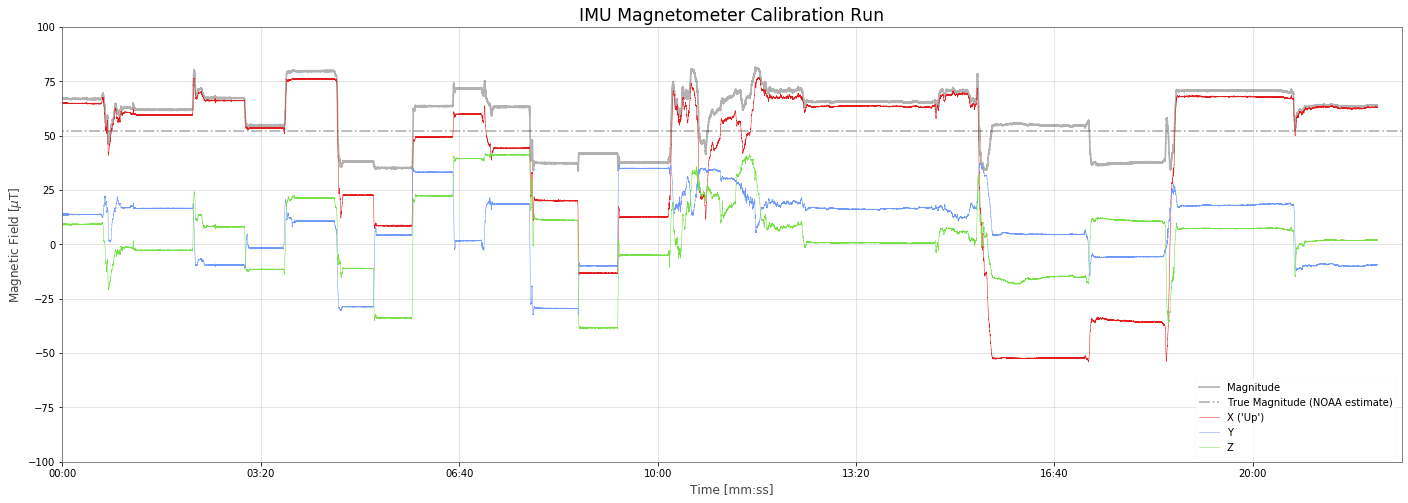

In [4]:
fig, ax1 = plt.subplots(figsize=(24,8))
plt.title(r"IMU Magnetometer Calibration Run")
plt.ylabel(r"Magnetic Field [$ \mu$T]")
plt.xlabel(r"Time [mm:ss]")

plt.plot(time, raw_mag, 'k-', alpha=0.3, label="Magnitude")
plt.plot([-100,5000], [52.129, 52.129], 'k-.', alpha=0.3, label="True Magnitude (NOAA estimate)")
plt.plot(time, m_raw_x, lw=0.5, label="X ('Up')")
plt.plot(time, m_raw_y, lw=0.5, label="Y")
plt.plot(time, m_raw_z, lw=0.5, label="Z")

plt.xlim([0,1350])
plt.ylim([-100,100])
ax1.xaxis.set_major_formatter(FuncFormatter(minsec))
ax1.legend(loc=4)
plt.show()

This is because we have a couple of problems. One is that the effective _center_ of our magnetometer values are pushed off to one side. And the other is that the values are skewed (or "stretched") off to one side as well. This is somewhat easier to see in 3D:

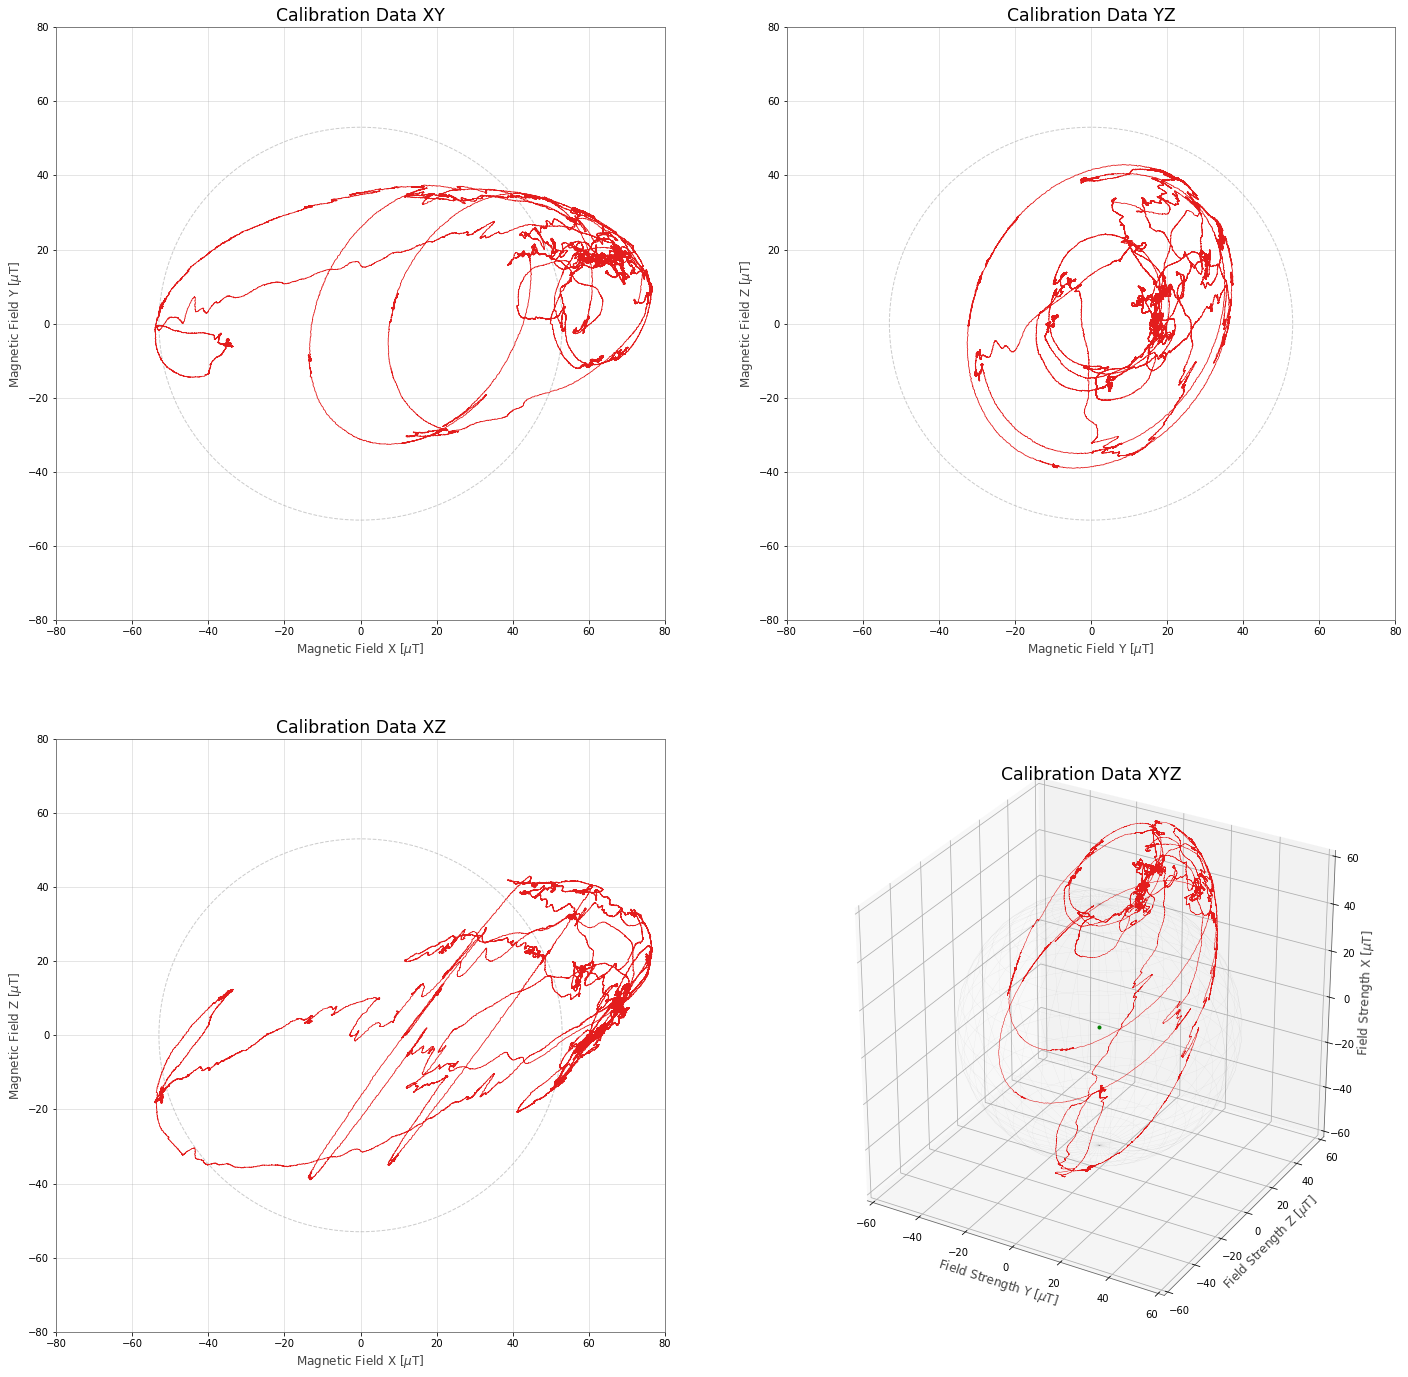

In [5]:

fig = plt.figure(figsize=(24,24))
gs = gridspec.GridSpec(2, 2, width_ratios=[1, 1])

ax1 = plt.subplot(gs[0])
plt.title(r"Calibration Data XY")
plt.xlabel(r"Magnetic Field X [$ \mu$T]")
plt.ylabel(r"Magnetic Field Y [$ \mu$T]")
ax1.plot(m_raw_x, m_raw_y, lw=0.8, label="")
ax1.add_patch(patches.Circle((0, 0), 53, edgecolor="#cccccc", linewidth=1.0, linestyle='--', fill=False))
plt.xlim([-80,80])
plt.ylim([-80,80])

ax2 = plt.subplot(gs[1])
plt.title(r"Calibration Data YZ")
plt.xlabel(r"Magnetic Field Y [$ \mu$T]")
plt.ylabel(r"Magnetic Field Z [$ \mu$T]")
ax2.plot(m_raw_y, m_raw_z, lw=0.8, label="")
ax2.add_patch(patches.Circle((0, 0), 53, edgecolor="#cccccc", linewidth=1.0, linestyle='--', fill=False))
plt.xlim([-80,80])
plt.ylim([-80,80])

ax3 = plt.subplot(gs[2])
plt.title(r"Calibration Data XZ")
plt.xlabel(r"Magnetic Field X [$ \mu$T]")
plt.ylabel(r"Magnetic Field Z [$ \mu$T]")
ax3.plot(m_raw_x, m_raw_z, lw=0.8, label="")
ax3.add_patch(patches.Circle((0, 0), 53, edgecolor="#cccccc", linewidth=1.0, linestyle='--', fill=False))
plt.xlim([-80,80])
plt.ylim([-80,80])

ax4 = plt.subplot(gs[3], projection='3d')
plt.title(r"Calibration Data XYZ")
plt.xlabel(r"Field Strength Y [$\mu$T]")
plt.ylabel(r"Field Strength Z [$\mu$T]")
ax4.set_zlabel('Field Strength X [$\mu$T]')

ax4.plot_wireframe(x, y, z, color="k", alpha=0.1, lw=0.2)

ax4.plot(m_raw_y, m_raw_z, m_raw_x, '-', lw=0.5)
ax4.plot([0],[0],[0], 'g.')

ax4.set_xlim(-60, 60)
ax4.set_ylim(-60, 60)
ax4.set_zlim(-60, 60)

plt.show()

## Correction

The two parts of the correction are called "Hard Iron" (fixed center offset) and "Soft Iron" (streched sphere) corrections.

### Hard Iron

This is the simpler of the two, one can essentially find the midrange value of across the entire calibration dataset and subtract that offset to move the '0' point back to center.

### Soft Iron

Finding the soft iron correction is a bit trickier because we want to fit an matching elongated ellipsoid to the data, and then once we have an approximation for that ellipsoid apply stretch to the data to undo the elongation and get it back to a sphere. Luckily an algorithm for this has been worked out. For a detailed breakdown see

https://teslabs.com/articles/magnetometer-calibration/

After doing fitting we end up with both a correction matrix and an offset vector. This is both the soft iron and hard iron correction.

To invert the stretch we multiply a vector representing each magnetometer reading (a 'sample', $\vec s$) by the correction matrix (after subtracting the center offset).

$$
\vec s_\textrm{corrected} = \mathbf{A} \cdot (\vec s - \vec b)
$$

Where

 - $\vec s_\textrm{corrected}$ is a fully corrected sample at time t
 - $\mathbf{A}$ is our soft iron correction matrix
 - $\vec s$ is a raw sample from the IMU at time t
 - $\vec b$ our hard iron offset vector.

When we solve for $\mathbf{A}$ on the calibration data we get the matrix:

In [6]:
def ellipsoid_fit(s):
    ''' Estimate ellipsoid parameters from a set of points.

        Parameters
        ----------
        s : array_like
          The samples (M,N) where M=3 (x,y,z) and N=number of samples.

        Returns
        -------
        M, n, d : array_like, array_like, float
          The ellipsoid parameters M, n, d.

        References
        ----------
        .. [1] Qingde Li; Griffiths, J.G., "Least squares ellipsoid specific
           fitting," in Geometric Modeling and Processing, 2004.
           Proceedings, vol., no., pp.335-340, 2004
    '''

    # D (samples)
    D = np.array([s[0]**2., s[1]**2., s[2]**2.,
                  2.*s[1]*s[2], 2.*s[0]*s[2], 2.*s[0]*s[1],
                  2.*s[0], 2.*s[1], 2.*s[2], np.ones_like(s[0])])

    # S, S_11, S_12, S_21, S_22 (eq. 11)
    S = np.dot(D, D.T)
    S_11 = S[:6,:6]
    S_12 = S[:6,6:]
    S_21 = S[6:,:6]
    S_22 = S[6:,6:]

    # C (Eq. 8, k=4)
    C = np.array([[-1,  1,  1,  0,  0,  0],
                  [ 1, -1,  1,  0,  0,  0],
                  [ 1,  1, -1,  0,  0,  0],
                  [ 0,  0,  0, -4,  0,  0],
                  [ 0,  0,  0,  0, -4,  0],
                  [ 0,  0,  0,  0,  0, -4]])

    # v_1 (eq. 15, solution)
    E = np.dot(linalg.inv(C), S_11 - np.dot(S_12, np.dot(linalg.inv(S_22), S_21)))

    E_w, E_v = linalg.eig(E)

    v_1 = E_v[:, np.argmax(E_w)]
    if v_1[0] < 0: v_1 = -v_1

    # v_2 (eq. 13, solution)
    v_2 = np.dot(np.dot(-linalg.inv(S_22), S_21), v_1)

    # quadric-form parameters
    M = np.array([[v_1[0], v_1[3], v_1[4]],
                  [v_1[3], v_1[1], v_1[5]],
                  [v_1[4], v_1[5], v_1[2]]])
    n = np.array([[v_2[0]],
                  [v_2[1]],
                  [v_2[2]]])
    d = v_2[3]

    return M, n, d

In [7]:
# samples
s = []
for i, t in enumerate(time):
    s.append((m_raw_x[i], m_raw_y[i], m_raw_z[i]))

M, n, d = ellipsoid_fit(np.array(s).T)



F = true_magnitude

M_1 = linalg.inv(M)
b = np.dot(M_1, n)
A_1 = np.real(F / np.sqrt(np.dot(n.T, np.dot(M_1, n)) - d) * linalg.sqrtm(M))

#print(A_1)
#print(b)

In [8]:
Markdown(f"""
$$
\\textbf{{A}} = \\left[\\begin{{array}}{{ccc}}
 {A_1[0][0]:0.6f} & {A_1[0][1]:0.6f} & {A_1[0][2]:0.6f} \\\\\\\\
 {A_1[1][0]:0.6f} & {A_1[1][1]:0.6f} & {A_1[1][2]:0.6f} \\\\\\\\
 {A_1[2][0]:0.6f} & {A_1[2][1]:0.6f} & {A_1[2][2]:0.6f}
\\end{{array}}\\right]
$$
""")


$$
\textbf{A} = \left[\begin{array}{ccc}
 0.870368 & -0.128543 & -0.283684 \\\\
 -0.128543 & 1.510386 & -0.046543 \\\\
 -0.283684 & -0.046543 & 1.440805
\end{array}\right]
$$


And a hard iron offset vector:

In [9]:
Markdown(f"""
$$
\\vec b = \\left[ \\begin{{array}}{{ccc}}
{b[0][0]:0.6f} & {b[1][0]:0.6f} & {b[2][0]:0.6f}
\\end{{array}}\\right]
$$
""")


$$
\vec b = \left[ \begin{array}{ccc}
-12.019415 & -3.209783 & -1.939041
\end{array}\right]
$$


## Python

If we want to apply this correction we can make a convienient function to call on all our samples:

In [10]:
def apply_mag_correction(sample):
    return np.dot(A_1, sample + b)

In [11]:
Markdown(f"""
``` python
import numpy as np

MAG_CORRECTION_A = np.array((
    ({A_1[0][0]:15.12f}, {A_1[0][1]:15.12f}, {A_1[0][2]:15.12f}),
    ({A_1[1][0]:15.12f}, {A_1[1][1]:15.12f}, {A_1[1][2]:15.12f}),
    ({A_1[2][0]:15.12f}, {A_1[2][1]:15.12f}, {A_1[2][2]:15.12f}),
))

MAG_CORRECTION_b = np.array(({b[0][0]:15.12f}, {b[1][0]:15.12f}, {b[2][0]:15.12f}))

def apply_mag_correction(sample):
    \"""Take a sample and correct for hard and soft iron effects
    based on calibration run before Launch 12.
    
    :param sample: Vector (np.array) (x,y,z) instantaintous magnetometer reading
    :returns: vector (x,y,z) corrected magnetometer reading
    \"""
    
    return np.dot(MAG_CORRECTION_A, sample + MAG_CORRECTION_b)
```
""")


``` python
import numpy as np

MAG_CORRECTION_A = np.array((
    ( 0.870367858077, -0.128543320363, -0.283683583608),
    (-0.128543320363,  1.510386103995, -0.046543028701),
    (-0.283683583608, -0.046543028701,  1.440804950101),
))

MAG_CORRECTION_b = np.array((-12.019414737824, -3.209782771540, -1.939040882716))

def apply_mag_correction(sample):
    """Take a sample and correct for hard and soft iron effects
    based on calibration run before Launch 12.
    
    :param sample: Vector (np.array) (x,y,z) instantaintous magnetometer reading
    :returns: vector (x,y,z) corrected magnetometer reading
    """
    
    return np.dot(MAG_CORRECTION_A, sample + MAG_CORRECTION_b)
```


## Apply Calibration

After we apply the calibration fix above, do we get a better result?

In [12]:
mag = []
m_x = []
m_y = []
m_z = []
for i, t in enumerate(time):
    s = np.array((m_raw_x[i], m_raw_y[i], m_raw_z[i])).reshape(3, 1)
    s = apply_mag_correction(s)
    mx, my, mz = s[0][0], s[1][0], s[2][0]
    m_x.append(mx)
    m_y.append(my)
    m_z.append(mz)
    mag.append(np.sqrt((mx*mx) + (my*my) + (mz*mz)))

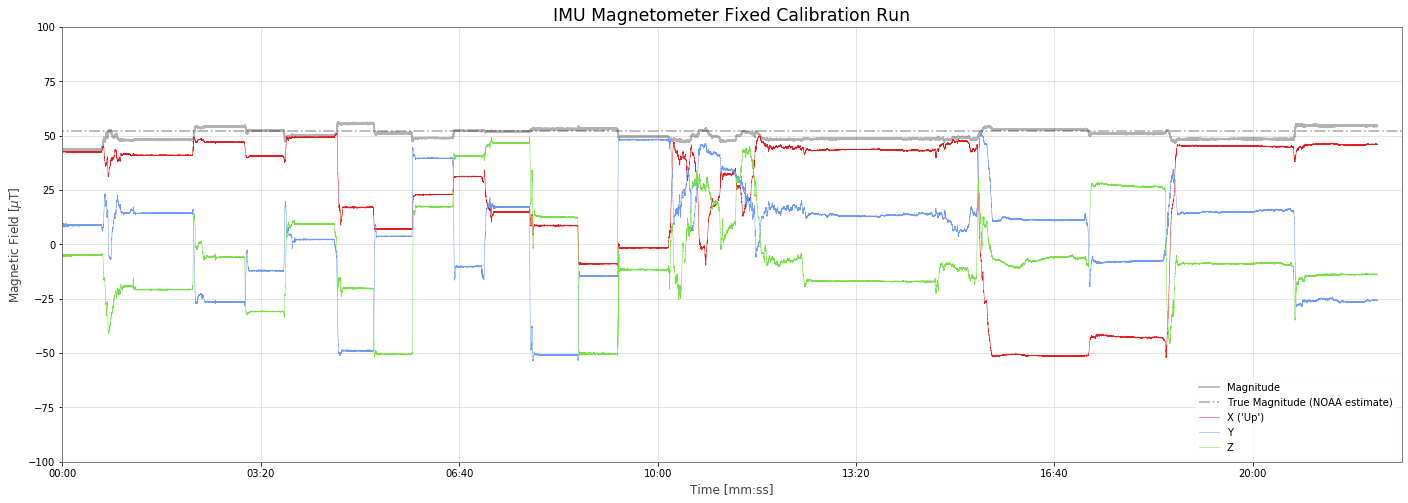

In [13]:
fig, ax1 = plt.subplots(figsize=(24,8))
plt.title(r"IMU Magnetometer Fixed Calibration Run")
plt.ylabel(r"Magnetic Field [$ \mu$T]")
plt.xlabel(r"Time [mm:ss]")

plt.plot(time, mag, 'k-', alpha=0.3, label="Magnitude")
plt.plot([-100,5000], [52.129, 52.129], 'k-.', alpha=0.3, label="True Magnitude (NOAA estimate)")
plt.plot(time, m_x, lw=0.5, label="X ('Up')")
plt.plot(time, m_y, lw=0.5, label="Y")
plt.plot(time, m_z, lw=0.5, label="Z")

plt.xlim([0,1350])
plt.ylim([-100,100])
ax1.xaxis.set_major_formatter(FuncFormatter(minsec))
ax1.legend(loc=4)
plt.show()

Yes! Quite a bit better. Notice how the magnitue of the vector now stays very close to constant and is very close to the NOAA estimate!

Again in 3D we can see a much closer to spherical data:

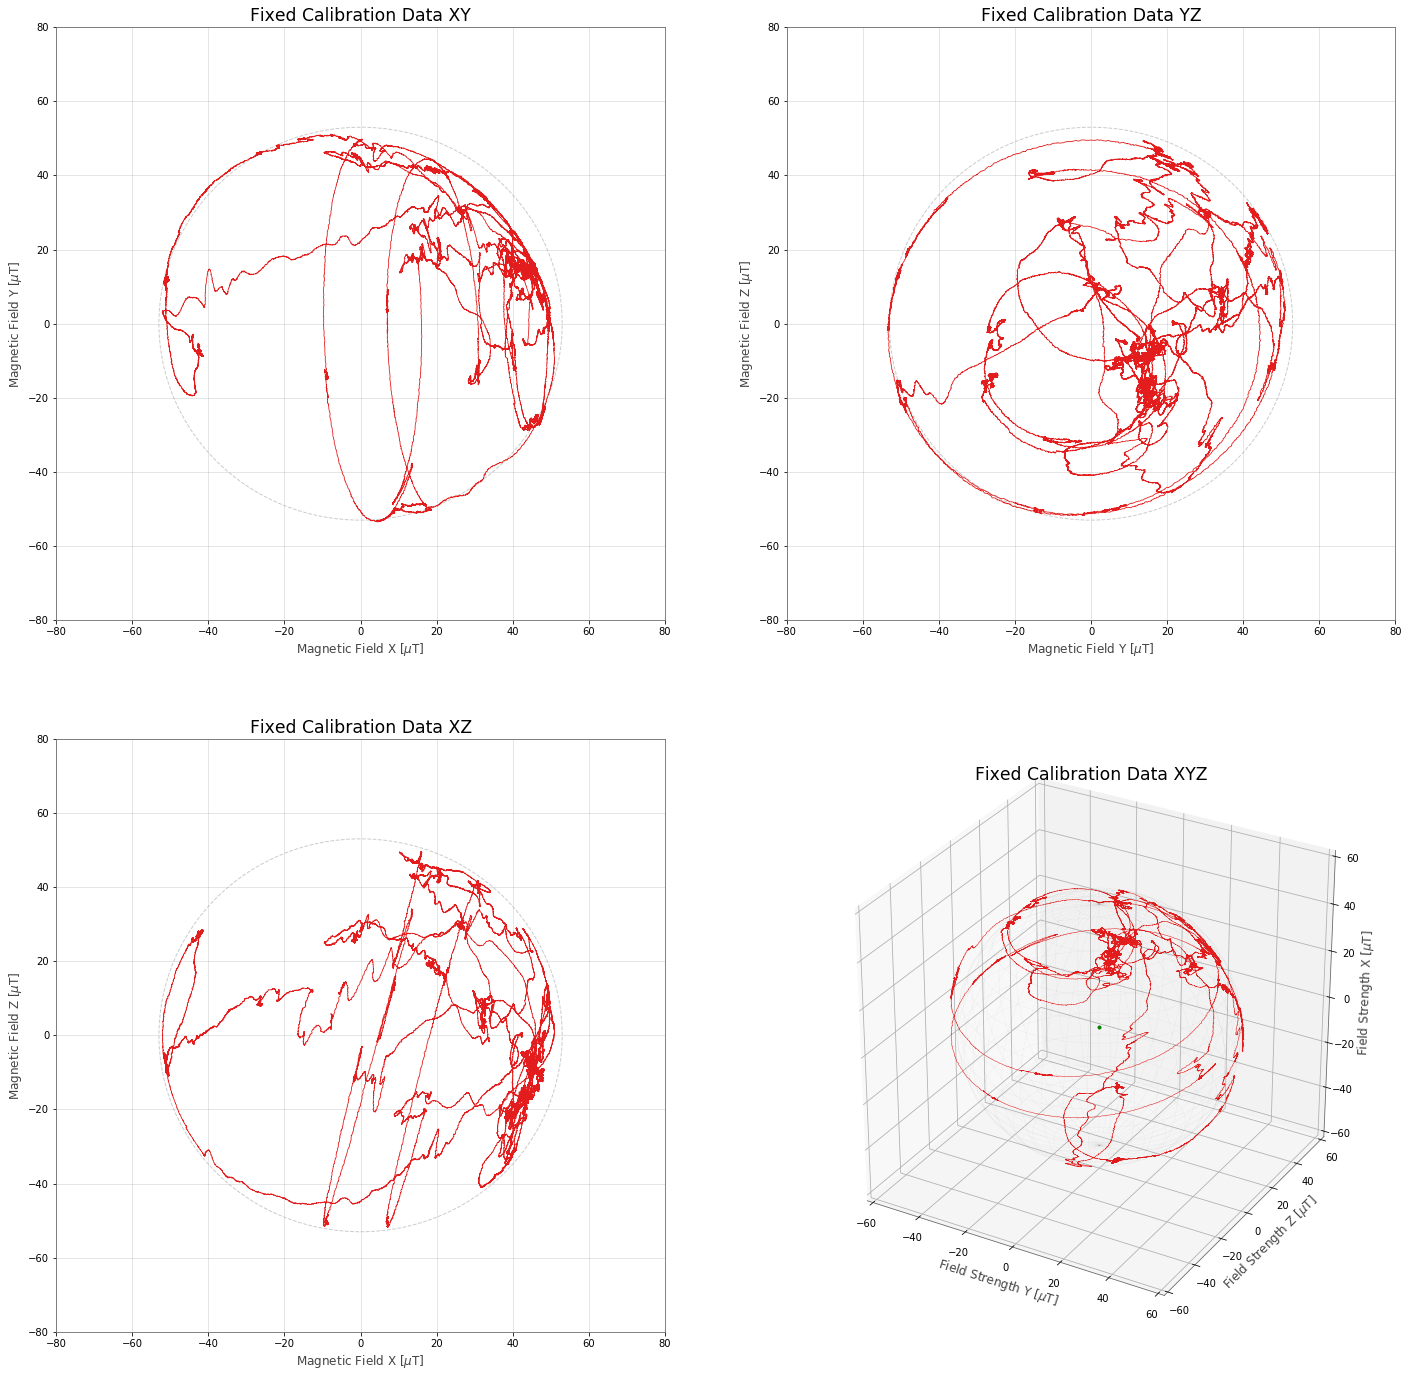

In [14]:

fig = plt.figure(figsize=(24,24))
gs = gridspec.GridSpec(2, 2, width_ratios=[1, 1])

ax1 = plt.subplot(gs[0])
plt.title(r"Fixed Calibration Data XY")
plt.xlabel(r"Magnetic Field X [$ \mu$T]")
plt.ylabel(r"Magnetic Field Y [$ \mu$T]")
ax1.plot(m_x, m_y, lw=0.8, label="")
ax1.add_patch(patches.Circle((0, 0), 53, edgecolor="#cccccc", linewidth=1.0, linestyle='--', fill=False))
plt.xlim([-80,80])
plt.ylim([-80,80])

ax2 = plt.subplot(gs[1])
plt.title(r"Fixed Calibration Data YZ")
plt.xlabel(r"Magnetic Field Y [$ \mu$T]")
plt.ylabel(r"Magnetic Field Z [$ \mu$T]")
ax2.plot(m_y, m_z, lw=0.8, label="")
ax2.add_patch(patches.Circle((0, 0), 53, edgecolor="#cccccc", linewidth=1.0, linestyle='--', fill=False))
plt.xlim([-80,80])
plt.ylim([-80,80])

ax3 = plt.subplot(gs[2])
plt.title(r"Fixed Calibration Data XZ")
plt.xlabel(r"Magnetic Field X [$ \mu$T]")
plt.ylabel(r"Magnetic Field Z [$ \mu$T]")
ax3.plot(m_x, m_z, lw=0.8, label="")
ax3.add_patch(patches.Circle((0, 0), 53, edgecolor="#cccccc", linewidth=1.0, linestyle='--', fill=False))
plt.xlim([-80,80])
plt.ylim([-80,80])

ax4 = plt.subplot(gs[3], projection='3d')
plt.title(r"Fixed Calibration Data XYZ")
plt.xlabel(r"Field Strength Y [$\mu$T]")
plt.ylabel(r"Field Strength Z [$\mu$T]")
ax4.set_zlabel('Field Strength X [$\mu$T]')

ax4.plot_wireframe(x, y, z, color="k", alpha=0.1, lw=0.2)

ax4.plot(m_y, m_z, m_x, '-', lw=0.5)
ax4.plot([0],[0],[0], 'g.')

ax4.set_xlim(-60, 60)
ax4.set_ylim(-60, 60)
ax4.set_zlim(-60, 60)

plt.show()

## Applying to Flight Data

We can now take our calibration matrix and apply it to real flight data! Here is a 3D look at the [Launch-12](https://github.com/psas/Launch-12) **raw** (uncalibrated) magnetometer data from liftoff to apogee:

In [15]:
l12_data = h5py.File("data/L-12_flight.hdf5", "r")
l12_adis = l12_data["ADIS"]

l12_time = np.array(l12_adis["time"])

l12_m_raw_x = np.array(l12_adis["mag_x"]) * 1e6
l12_m_raw_y = np.array(l12_adis["mag_y"]) * 1e6
l12_m_raw_z = np.array(l12_adis["mag_z"]) * 1e6

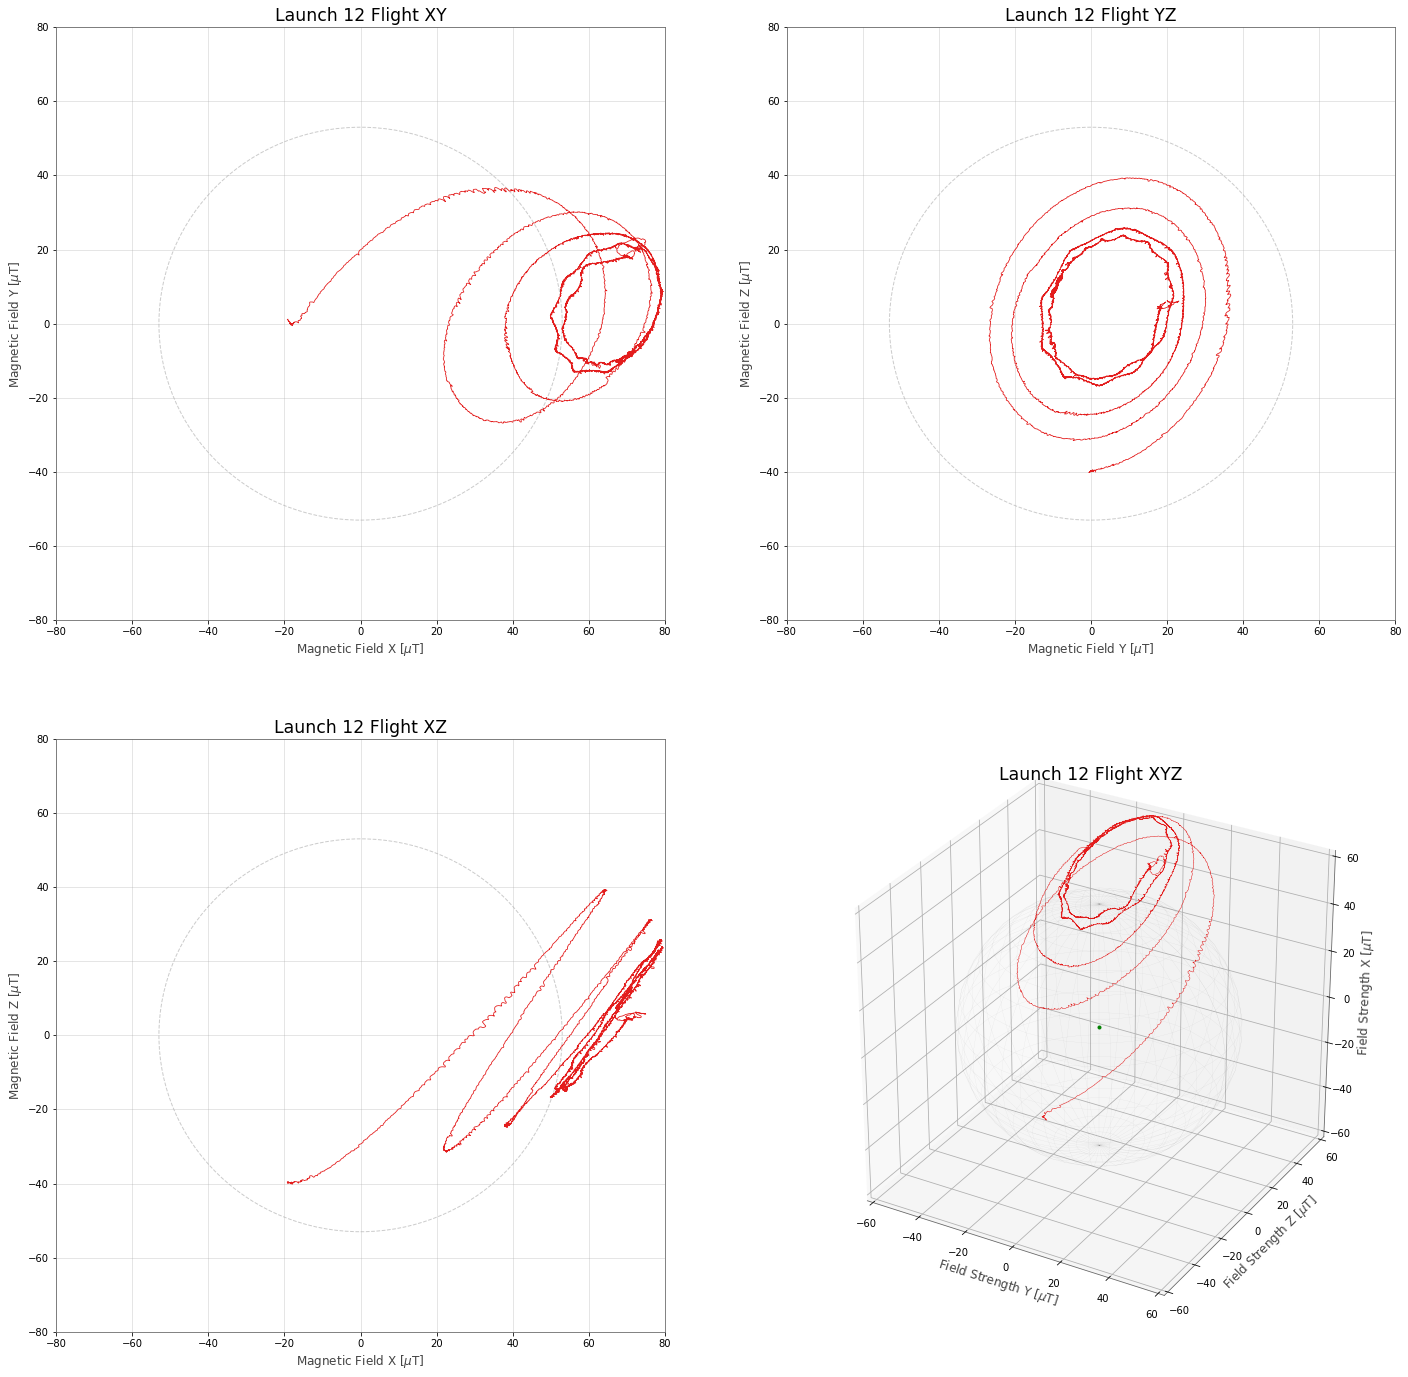

In [16]:
fig = plt.figure(figsize=(24,24))
gs = gridspec.GridSpec(2, 2, width_ratios=[1, 1])

ax1 = plt.subplot(gs[0])
plt.title(r"Launch 12 Flight XY")
plt.xlabel(r"Magnetic Field X [$ \mu$T]")
plt.ylabel(r"Magnetic Field Y [$ \mu$T]")
ax1.plot(l12_m_raw_x, l12_m_raw_y, lw=0.8, label="")
ax1.add_patch(patches.Circle((0, 0), 53, edgecolor="#cccccc", linewidth=1.0, linestyle='--', fill=False))
plt.xlim([-80,80])
plt.ylim([-80,80])

ax2 = plt.subplot(gs[1])
plt.title(r"Launch 12 Flight YZ")
plt.xlabel(r"Magnetic Field Y [$ \mu$T]")
plt.ylabel(r"Magnetic Field Z [$ \mu$T]")
ax2.plot(l12_m_raw_y, l12_m_raw_z, lw=0.8, label="")
ax2.add_patch(patches.Circle((0, 0), 53, edgecolor="#cccccc", linewidth=1.0, linestyle='--', fill=False))
plt.xlim([-80,80])
plt.ylim([-80,80])

ax3 = plt.subplot(gs[2])
plt.title(r"Launch 12 Flight XZ")
plt.xlabel(r"Magnetic Field X [$ \mu$T]")
plt.ylabel(r"Magnetic Field Z [$ \mu$T]")
ax3.plot(l12_m_raw_x, l12_m_raw_z, lw=0.8, label="")
ax3.add_patch(patches.Circle((0, 0), 53, edgecolor="#cccccc", linewidth=1.0, linestyle='--', fill=False))
plt.xlim([-80,80])
plt.ylim([-80,80])

ax4 = plt.subplot(gs[3], projection='3d')
plt.title(r"Launch 12 Flight XYZ")
plt.xlabel(r"Field Strength Y [$\mu$T]")
plt.ylabel(r"Field Strength Z [$\mu$T]")
ax4.set_zlabel('Field Strength X [$\mu$T]')

ax4.plot_wireframe(x, y, z, color="k", alpha=0.1, lw=0.2)

ax4.plot(l12_m_raw_y, l12_m_raw_z, l12_m_raw_x, '-', lw=0.5)
ax4.plot([0],[0],[0], 'g.')

ax4.set_xlim(-60, 60)
ax4.set_ylim(-60, 60)
ax4.set_zlim(-60, 60)

plt.show()

The rocket spins during flight, and we see the magnetic field measurement spiral around the plots. We also see the familiar stretch and offset that we saw in the calibration data.


### Calibrated Flight Data

So now lets calibrate the flight data!

In [17]:
l12_m_x = []
l12_m_y = []
l12_m_z = []
for i, t in enumerate(l12_time):
    s = np.array((l12_m_raw_x[i], l12_m_raw_y[i], l12_m_raw_z[i])).reshape(3, 1)
    s = apply_mag_correction(s)
    mx, my, mz = s[0][0], s[1][0], s[2][0]
    l12_m_x.append(mx)
    l12_m_y.append(my)
    l12_m_z.append(mz)

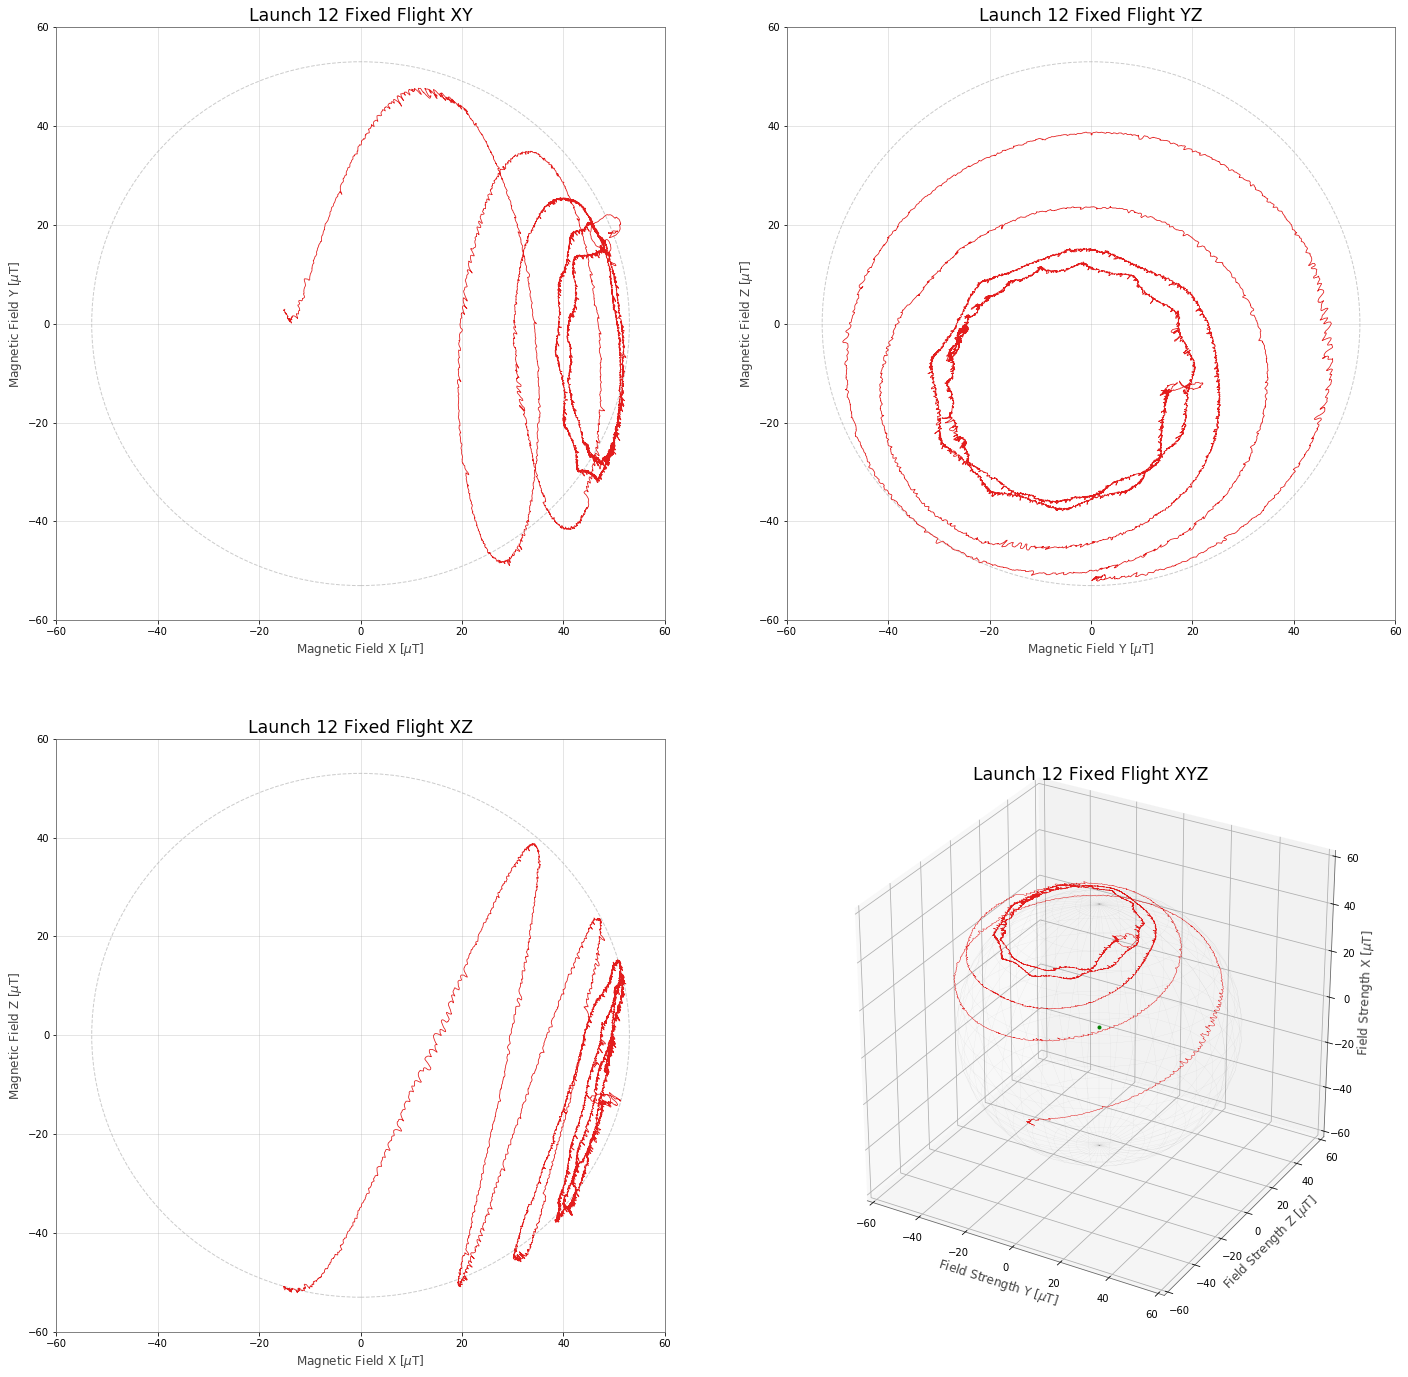

In [18]:
fig = plt.figure(figsize=(24,24))
gs = gridspec.GridSpec(2, 2, width_ratios=[1, 1])

ax1 = plt.subplot(gs[0])
plt.title(r"Launch 12 Fixed Flight XY")
plt.xlabel(r"Magnetic Field X [$ \mu$T]")
plt.ylabel(r"Magnetic Field Y [$ \mu$T]")
ax1.plot(l12_m_x, l12_m_y, lw=0.8, label="")
ax1.add_patch(patches.Circle((0, 0), 53, edgecolor="#cccccc", linewidth=1.0, linestyle='--', fill=False))
plt.xlim([-60,60])
plt.ylim([-60,60])

ax2 = plt.subplot(gs[1])
plt.title(r"Launch 12 Fixed Flight YZ")
plt.xlabel(r"Magnetic Field Y [$ \mu$T]")
plt.ylabel(r"Magnetic Field Z [$ \mu$T]")
ax2.plot(l12_m_y, l12_m_z, lw=0.8, label="")
ax2.add_patch(patches.Circle((0, 0), 53, edgecolor="#cccccc", linewidth=1.0, linestyle='--', fill=False))
plt.xlim([-60,60])
plt.ylim([-60,60])

ax3 = plt.subplot(gs[2])
plt.title(r"Launch 12 Fixed Flight XZ")
plt.xlabel(r"Magnetic Field X [$ \mu$T]")
plt.ylabel(r"Magnetic Field Z [$ \mu$T]")
ax3.plot(l12_m_x, l12_m_z, lw=0.8, label="")
ax3.add_patch(patches.Circle((0, 0), 53, edgecolor="#cccccc", linewidth=1.0, linestyle='--', fill=False))
plt.xlim([-60,60])
plt.ylim([-60,60])

ax4 = plt.subplot(gs[3], projection='3d')
plt.title(r"Launch 12 Fixed Flight XYZ")
plt.xlabel(r"Field Strength Y [$\mu$T]")
plt.ylabel(r"Field Strength Z [$\mu$T]")
ax4.set_zlabel('Field Strength X [$\mu$T]')

ax4.plot_wireframe(x, y, z, color="k", alpha=0.1, lw=0.2)

ax4.plot(l12_m_y, l12_m_z, l12_m_x, '-', lw=0.5)
ax4.plot([0],[0],[0], 'g.')

ax4.set_xlim(-60, 60)
ax4.set_ylim(-60, 60)
ax4.set_zlim(-60, 60)

plt.show()

And it looks like the calibration did a reasonable job. The values now come very close to landing on the nominal Earth field sphere. The XY view is still off a little bit but it might just be that we had some bias in the calibration run. It's still a huge improvement to the original dataset and it now usable in IMU reconstructions of the flight of the rocket.

----------------------------------------------

This post is written as a [jupyter notebook](https://jupyter.org/) and all its code and data can be viewed as a stand-alone own project here:

https://git.natronics.org/natronics/psas-magnetometer-calibration